### Test the trained network

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


### Hyperparameters
batch_size = 1 
k = 4
d = 3


/Users/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Network to load

In [2]:
timestamp = "2018-05-30_02:19"

epoch = 200

- Load gmm params

In [3]:
import numpy as np

In [4]:
filename=timestamp + "-gmmParams.npz"

with np.load(filename) as data:
    phi = data["phi"]
    mu = data["mu"]
    sigma = data["sigma"]
    

In [5]:
phi = K.constant(phi)
mu = K.constant(mu)
sigma = K.constant(sigma)

In [6]:
K.eval(phi)

array([0.25, 0.25, 0.25, 0.25], dtype=float32)

In [7]:
K.eval(mu)

array([[0.83827037, 0.83827037, 0.83827037],
       [0.83827037, 0.83827037, 0.83827037],
       [0.83827037, 0.83827037, 0.83827037],
       [0.83827037, 0.83827037, 0.83827037]], dtype=float32)

In [8]:
K.eval(sigma)

array([[[ 1.1134834 , -0.16407748,  0.8257783 ],
        [-0.16407748,  0.02514663, -0.12420237],
        [ 0.8257783 , -0.12420237,  0.6192002 ]],

       [[ 1.1134834 , -0.16407748,  0.8257783 ],
        [-0.16407748,  0.02514663, -0.12420237],
        [ 0.8257783 , -0.12420237,  0.6192002 ]],

       [[ 1.1134834 , -0.16407748,  0.8257783 ],
        [-0.16407748,  0.02514663, -0.12420237],
        [ 0.8257783 , -0.12420237,  0.6192002 ]],

       [[ 1.1134834 , -0.16407748,  0.8257783 ],
        [-0.16407748,  0.02514663, -0.12420237],
        [ 0.8257783 , -0.12420237,  0.6192002 ]]], dtype=float32)

- Plot loss history

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [11]:
def plotHistory(loss_array, save=False, savename=timestamp+"-lossGraph.png"):
    fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax.set_title("Loss graph for end-to-end training")

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.plot(loss_array)
    
    if save:
        plt.savefig(savename)

In [12]:
filename = timestamp + "-history.npz"
with np.load(filename) as data:
    history = data["history"]

history = history.ravel()[0]["loss"]

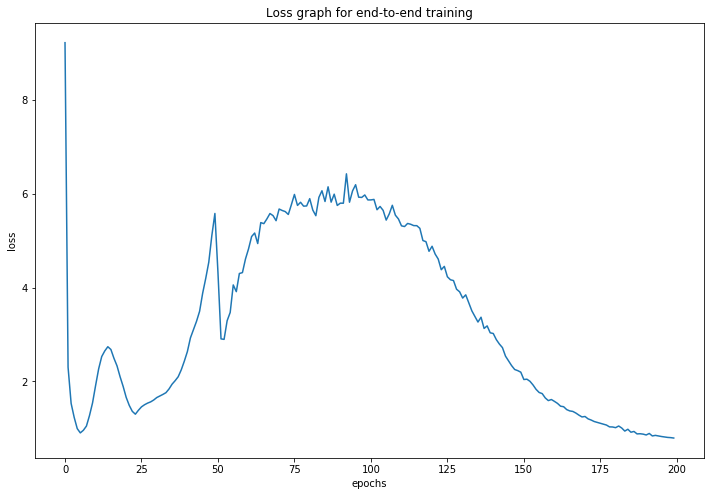

In [13]:
plotHistory(history, save=True)

- Network definition for testing

In [14]:
### Define compresion network

input_data = Input(batch_shape=(batch_size,120), name='input_placeholder')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

layer_lowdim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(layer_lowdim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



### Define similarity metrics

def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

### Obtain "z"
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])


### Sample energy as a lambda function at the end
def computeEnergy(z_i):
    inside_sum = tf.zeros(()) 
    for cluster in range(k):
        diff = tf.reshape(z_i - mu[cluster], (1,-1))   ### (1,3)
        diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

        sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
        
        exp_term = tf.exp(-0.5 * tf.matmul(diff, tf.matmul(sigma_inv, diff_t)))    ### (1,1)

        denom = tf.sqrt(tf.linalg.det(2 * np.pi * sigma[cluster]))
        
        inside_sum += phi[cluster] * (exp_term / denom)   ### (1,1)
        
        
    inside_sum = tf.reshape(inside_sum, ())
    
    sample_energy = -tf.log(inside_sum + 1e-6) 
    
    
    return sample_energy

def energyCalc(yTrue, yPred):
    
    z = layer_concat

    return computeEnergy(z)


layer_energy = Lambda(computeEnergy,
                      name='sample_energy')([layer_concat])




eval_net = Model(input=input_data, outputs=layer_energy)

eval_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (1, 120)             0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1, 60)              7260        input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (1, 30)              1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (1, 10)              310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

/Users/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("sa..., inputs=Tensor("in...)`


- Load trained weights

In [15]:
filename = timestamp + "-modelsave_weights-epochs{}.h5".format(epoch)
eval_net.load_weights(filename, by_name=True)

- Load dataset

In [16]:
import numpy as np

In [19]:
with np.load('../datasets/kddcup/kdd99_test-randomState_None.npz') as data:  ### kdd99_test
    x_test = data['x_test']

In [20]:
normal_data = x_test[np.where(x_test[:,-1] == 1)]

In [21]:
anomaly_data = x_test[np.where(x_test[:,-1] == 0)]

In [22]:
normal_data.shape

(198366, 120)

In [23]:
anomaly_data.shape

(48645, 120)

### Obtain sample energies

- Energies from normal class

In [24]:
energies_normal = eval_net.predict(normal_data, batch_size=1, verbose=1)  

198366/198366 [==============================] - 123s 619us/step


In [25]:
energies_normal

array([-4.2711134, -4.2711134, -4.2711134, ..., -4.2667127, -4.271142 ,
       -4.271142 ], dtype=float32)

In [26]:
energies_normal.min()

-4.2819934

In [27]:
energies_normal.max()

13.815511

In [28]:
hist_bins = 500

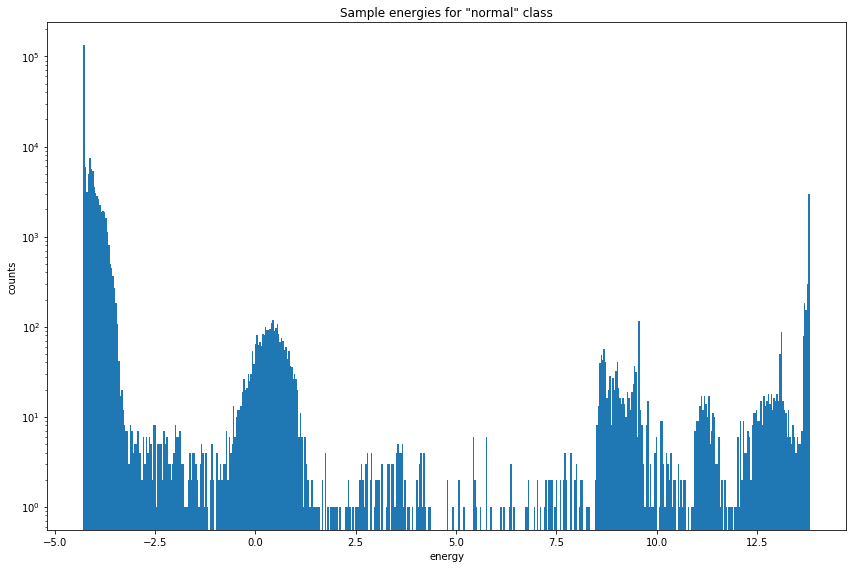

In [29]:
plt.hist(energies_normal, bins=hist_bins, log=True)

plt.title("Sample energies for \"normal\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-normalHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

- Energies from anomaly class

In [30]:
energies_anomaly = eval_net.predict(anomaly_data, batch_size=1, verbose=1)  

48645/48645 [==============================] - 31s 642us/step


In [31]:
energies_anomaly

array([13.815511, 13.815511, 13.815511, ..., 13.815457, 13.815511,
       13.815511], dtype=float32)

In [32]:
energies_anomaly.min()

13.807363

In [33]:
energies_anomaly.max()

13.815511

In [34]:
plt.hist?

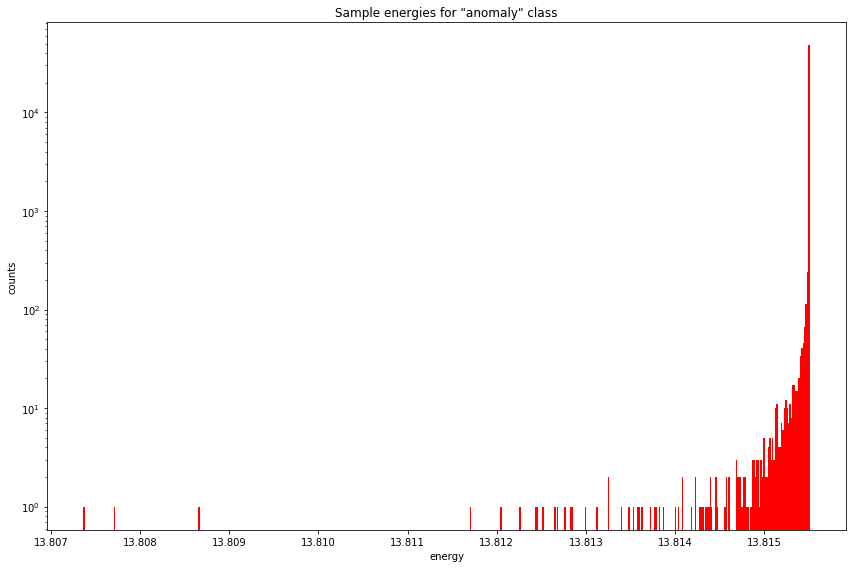

In [35]:
plt.hist(energies_anomaly, bins=hist_bins, color="red", log=True)

plt.title("Sample energies for \"anomaly\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-anomalyHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

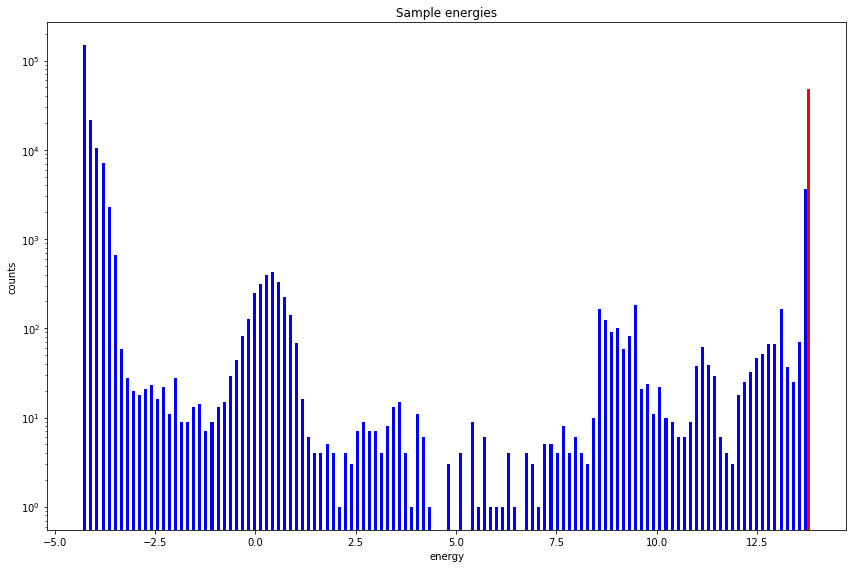

In [36]:
hist_bins = 120

plt.hist((energies_normal, energies_anomaly), 
         bins=hist_bins, 
         color=["blue", "red"], 
         histtype="bar", 
         label=["normal", "anomaly"], 
         rwidth=1.0,
         stacked=False,
         log=True)

plt.title("Sample energies")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-allHist_bins{}.png".format(hist_bins)
plt.savefig(filename)


### Find the threshold for classifying as anomaly: "top %20 of highest energy"

In [37]:
energies_all = np.concatenate((energies_normal, energies_anomaly), axis=0)

In [38]:
energies_all.shape

(247011,)

- Sort calculated energies descending

In [39]:
sorted_energies = np.sort(energies_all)[::-1]

In [40]:
sorted_energies

array([13.815511 , 13.815511 , 13.815511 , ..., -4.2819934, -4.2819934,
       -4.2819934], dtype=float32)

- Top %20 percent is the first %20 part of it

In [41]:
threshold_index = int(np.floor(len(sorted_energies) * 0.2))

In [42]:
sorted_energies[:threshold_index]

array([13.815511, 13.815511, 13.815511, ..., 13.815504, 13.815504,
       13.815504], dtype=float32)

In [43]:
threshold = sorted_energies[threshold_index]

- Below this threshold, samples are classified as normal

In [44]:
threshold

13.815504

### Calculate metrics

- "Anomaly class is positive" (from paper)

|                   | anomaly | normal |   |   |
|-------------------|---------|--------|---|---|
| predicted anomaly | TP      | FP     |   |   |
| predicted normal  | FN      | TN     |   |   |
|                   |         |        |   |   |

In [52]:
tp = len(energies_anomaly[energies_anomaly >= threshold])+ 0.00001
fp = len(energies_normal[energies_normal > threshold])+ 0.00001

tn = len(energies_normal[energies_normal <= threshold])
fn = len(energies_anomaly[energies_anomaly < threshold])+ 0.00001

In [53]:
precision = tp / (tp + fp)

In [54]:
precision

0.9600979834561105

In [55]:
recall = tp / (tp + fn)

In [56]:
recall

0.9749203410525561

In [57]:
f1 = 2*tp / (2*tp + fp + fn)

In [58]:
f1

0.9674523921757417

In [59]:

precision_vals = []
anomaly_percentage_vals = []
recall_vals = []
f1_vals = []

for anomaly_percentage in range(0,10000, 1):
    print(anomaly_percentage)
    threshold_index = int(np.floor(len(sorted_energies) * anomaly_percentage/10000))
    threshold = sorted_energies[threshold_index]
    tp = len(energies_anomaly[energies_anomaly >= threshold]) + 0.00001
    fp = len(energies_normal[energies_normal > threshold]) + 0.00001

    tn = len(energies_normal[energies_normal <= threshold])
    fn = len(energies_anomaly[energies_anomaly < threshold]) + 0.00001
    print(tp, fp, tn, fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*tp / (2*tp + fp + fn)
    
    precision_vals.append(precision)
    anomaly_percentage_vals.append(anomaly_percentage)
    recall_vals.append(recall)
    f1_vals.append(f1)

0
44869.00001 1e-05 198366 3776.00001
1
44869.00001 1e-05 198366 3776.00001
2
44869.00001 1e-05 198366 3776.00001
3
44869.00001 1e-05 198366 3776.00001
4
44869.00001 1e-05 198366 3776.00001
5
44869.00001 1e-05 198366 3776.00001
6
44869.00001 1e-05 198366 3776.00001
7
44869.00001 1e-05 198366 3776.00001
8
44869.00001 1e-05 198366 3776.00001
9
44869.00001 1e-05 198366 3776.00001
10
44869.00001 1e-05 198366 3776.00001
11
44869.00001 1e-05 198366 3776.00001
12
44869.00001 1e-05 198366 3776.00001
13
44869.00001 1e-05 198366 3776.00001
14
44869.00001 1e-05 198366 3776.00001
15
44869.00001 1e-05 198366 3776.00001
16
44869.00001 1e-05 198366 3776.00001
17
44869.00001 1e-05 198366 3776.00001
18
44869.00001 1e-05 198366 3776.00001
19
44869.00001 1e-05 198366 3776.00001
20
44869.00001 1e-05 198366 3776.00001
21
44869.00001 1e-05 198366 3776.00001
22
44869.00001 1e-05 198366 3776.00001
23
44869.00001 1e-05 198366 3776.00001
24
44869.00001 1e-05 198366 3776.00001
25
44869.00001 1e-05 198366 3776.00

44869.00001 1e-05 198366 3776.00001
247
44869.00001 1e-05 198366 3776.00001
248
44869.00001 1e-05 198366 3776.00001
249
44869.00001 1e-05 198366 3776.00001
250
44869.00001 1e-05 198366 3776.00001
251
44869.00001 1e-05 198366 3776.00001
252
44869.00001 1e-05 198366 3776.00001
253
44869.00001 1e-05 198366 3776.00001
254
44869.00001 1e-05 198366 3776.00001
255
44869.00001 1e-05 198366 3776.00001
256
44869.00001 1e-05 198366 3776.00001
257
44869.00001 1e-05 198366 3776.00001
258
44869.00001 1e-05 198366 3776.00001
259
44869.00001 1e-05 198366 3776.00001
260
44869.00001 1e-05 198366 3776.00001
261
44869.00001 1e-05 198366 3776.00001
262
44869.00001 1e-05 198366 3776.00001
263
44869.00001 1e-05 198366 3776.00001
264
44869.00001 1e-05 198366 3776.00001
265
44869.00001 1e-05 198366 3776.00001
266
44869.00001 1e-05 198366 3776.00001
267
44869.00001 1e-05 198366 3776.00001
268
44869.00001 1e-05 198366 3776.00001
269
44869.00001 1e-05 198366 3776.00001
270
44869.00001 1e-05 198366 3776.00001
271


44869.00001 1e-05 198366 3776.00001
472
44869.00001 1e-05 198366 3776.00001
473
44869.00001 1e-05 198366 3776.00001
474
44869.00001 1e-05 198366 3776.00001
475
44869.00001 1e-05 198366 3776.00001
476
44869.00001 1e-05 198366 3776.00001
477
44869.00001 1e-05 198366 3776.00001
478
44869.00001 1e-05 198366 3776.00001
479
44869.00001 1e-05 198366 3776.00001
480
44869.00001 1e-05 198366 3776.00001
481
44869.00001 1e-05 198366 3776.00001
482
44869.00001 1e-05 198366 3776.00001
483
44869.00001 1e-05 198366 3776.00001
484
44869.00001 1e-05 198366 3776.00001
485
44869.00001 1e-05 198366 3776.00001
486
44869.00001 1e-05 198366 3776.00001
487
44869.00001 1e-05 198366 3776.00001
488
44869.00001 1e-05 198366 3776.00001
489
44869.00001 1e-05 198366 3776.00001
490
44869.00001 1e-05 198366 3776.00001
491
44869.00001 1e-05 198366 3776.00001
492
44869.00001 1e-05 198366 3776.00001
493
44869.00001 1e-05 198366 3776.00001
494
44869.00001 1e-05 198366 3776.00001
495
44869.00001 1e-05 198366 3776.00001
496


44869.00001 1e-05 198366 3776.00001
696
44869.00001 1e-05 198366 3776.00001
697
44869.00001 1e-05 198366 3776.00001
698
44869.00001 1e-05 198366 3776.00001
699
44869.00001 1e-05 198366 3776.00001
700
44869.00001 1e-05 198366 3776.00001
701
44869.00001 1e-05 198366 3776.00001
702
44869.00001 1e-05 198366 3776.00001
703
44869.00001 1e-05 198366 3776.00001
704
44869.00001 1e-05 198366 3776.00001
705
44869.00001 1e-05 198366 3776.00001
706
44869.00001 1e-05 198366 3776.00001
707
44869.00001 1e-05 198366 3776.00001
708
44869.00001 1e-05 198366 3776.00001
709
44869.00001 1e-05 198366 3776.00001
710
44869.00001 1e-05 198366 3776.00001
711
44869.00001 1e-05 198366 3776.00001
712
44869.00001 1e-05 198366 3776.00001
713
44869.00001 1e-05 198366 3776.00001
714
44869.00001 1e-05 198366 3776.00001
715
44869.00001 1e-05 198366 3776.00001
716
44869.00001 1e-05 198366 3776.00001
717
44869.00001 1e-05 198366 3776.00001
718
44869.00001 1e-05 198366 3776.00001
719
44869.00001 1e-05 198366 3776.00001
720


44869.00001 1e-05 198366 3776.00001
903
44869.00001 1e-05 198366 3776.00001
904
44869.00001 1e-05 198366 3776.00001
905
44869.00001 1e-05 198366 3776.00001
906
44869.00001 1e-05 198366 3776.00001
907
44869.00001 1e-05 198366 3776.00001
908
44869.00001 1e-05 198366 3776.00001
909
44869.00001 1e-05 198366 3776.00001
910
44869.00001 1e-05 198366 3776.00001
911
44869.00001 1e-05 198366 3776.00001
912
44869.00001 1e-05 198366 3776.00001
913
44869.00001 1e-05 198366 3776.00001
914
44869.00001 1e-05 198366 3776.00001
915
44869.00001 1e-05 198366 3776.00001
916
44869.00001 1e-05 198366 3776.00001
917
44869.00001 1e-05 198366 3776.00001
918
44869.00001 1e-05 198366 3776.00001
919
44869.00001 1e-05 198366 3776.00001
920
44869.00001 1e-05 198366 3776.00001
921
44869.00001 1e-05 198366 3776.00001
922
44869.00001 1e-05 198366 3776.00001
923
44869.00001 1e-05 198366 3776.00001
924
44869.00001 1e-05 198366 3776.00001
925
44869.00001 1e-05 198366 3776.00001
926
44869.00001 1e-05 198366 3776.00001
927


44869.00001 1e-05 198366 3776.00001
1160
44869.00001 1e-05 198366 3776.00001
1161
44869.00001 1e-05 198366 3776.00001
1162
44869.00001 1e-05 198366 3776.00001
1163
44869.00001 1e-05 198366 3776.00001
1164
44869.00001 1e-05 198366 3776.00001
1165
44869.00001 1e-05 198366 3776.00001
1166
44869.00001 1e-05 198366 3776.00001
1167
44869.00001 1e-05 198366 3776.00001
1168
44869.00001 1e-05 198366 3776.00001
1169
44869.00001 1e-05 198366 3776.00001
1170
44869.00001 1e-05 198366 3776.00001
1171
44869.00001 1e-05 198366 3776.00001
1172
44869.00001 1e-05 198366 3776.00001
1173
44869.00001 1e-05 198366 3776.00001
1174
44869.00001 1e-05 198366 3776.00001
1175
44869.00001 1e-05 198366 3776.00001
1176
44869.00001 1e-05 198366 3776.00001
1177
44869.00001 1e-05 198366 3776.00001
1178
44869.00001 1e-05 198366 3776.00001
1179
44869.00001 1e-05 198366 3776.00001
1180
44869.00001 1e-05 198366 3776.00001
1181
44869.00001 1e-05 198366 3776.00001
1182
44869.00001 1e-05 198366 3776.00001
1183
44869.00001 1e-0

44869.00001 1e-05 198366 3776.00001
1372
44869.00001 1e-05 198366 3776.00001
1373
44869.00001 1e-05 198366 3776.00001
1374
44869.00001 1e-05 198366 3776.00001
1375
44869.00001 1e-05 198366 3776.00001
1376
44869.00001 1e-05 198366 3776.00001
1377
44869.00001 1e-05 198366 3776.00001
1378
44869.00001 1e-05 198366 3776.00001
1379
44869.00001 1e-05 198366 3776.00001
1380
44869.00001 1e-05 198366 3776.00001
1381
44869.00001 1e-05 198366 3776.00001
1382
44869.00001 1e-05 198366 3776.00001
1383
44869.00001 1e-05 198366 3776.00001
1384
44869.00001 1e-05 198366 3776.00001
1385
44869.00001 1e-05 198366 3776.00001
1386
44869.00001 1e-05 198366 3776.00001
1387
44869.00001 1e-05 198366 3776.00001
1388
44869.00001 1e-05 198366 3776.00001
1389
44869.00001 1e-05 198366 3776.00001
1390
44869.00001 1e-05 198366 3776.00001
1391
44869.00001 1e-05 198366 3776.00001
1392
44869.00001 1e-05 198366 3776.00001
1393
44869.00001 1e-05 198366 3776.00001
1394
44869.00001 1e-05 198366 3776.00001
1395
44869.00001 1e-0

44869.00001 1e-05 198366 3776.00001
1588
44869.00001 1e-05 198366 3776.00001
1589
44869.00001 1e-05 198366 3776.00001
1590
44869.00001 1e-05 198366 3776.00001
1591
44869.00001 1e-05 198366 3776.00001
1592
44869.00001 1e-05 198366 3776.00001
1593
44869.00001 1e-05 198366 3776.00001
1594
44869.00001 1e-05 198366 3776.00001
1595
44869.00001 1e-05 198366 3776.00001
1596
44869.00001 1e-05 198366 3776.00001
1597
44869.00001 1e-05 198366 3776.00001
1598
44869.00001 1e-05 198366 3776.00001
1599
44869.00001 1e-05 198366 3776.00001
1600
44869.00001 1e-05 198366 3776.00001
1601
44869.00001 1e-05 198366 3776.00001
1602
44869.00001 1e-05 198366 3776.00001
1603
44869.00001 1e-05 198366 3776.00001
1604
44869.00001 1e-05 198366 3776.00001
1605
44869.00001 1e-05 198366 3776.00001
1606
44869.00001 1e-05 198366 3776.00001
1607
44869.00001 1e-05 198366 3776.00001
1608
44869.00001 1e-05 198366 3776.00001
1609
44869.00001 1e-05 198366 3776.00001
1610
44869.00001 1e-05 198366 3776.00001
1611
44869.00001 1e-0

44869.00001 1e-05 198366 3776.00001
1796
44869.00001 1e-05 198366 3776.00001
1797
44869.00001 1e-05 198366 3776.00001
1798
44869.00001 1e-05 198366 3776.00001
1799
44869.00001 1e-05 198366 3776.00001
1800
44869.00001 1e-05 198366 3776.00001
1801
44869.00001 1e-05 198366 3776.00001
1802
44869.00001 1e-05 198366 3776.00001
1803
44869.00001 1e-05 198366 3776.00001
1804
44869.00001 1e-05 198366 3776.00001
1805
44869.00001 1e-05 198366 3776.00001
1806
44869.00001 1e-05 198366 3776.00001
1807
44869.00001 1e-05 198366 3776.00001
1808
44869.00001 1e-05 198366 3776.00001
1809
44869.00001 1e-05 198366 3776.00001
1810
44869.00001 1e-05 198366 3776.00001
1811
44869.00001 1e-05 198366 3776.00001
1812
44869.00001 1e-05 198366 3776.00001
1813
44869.00001 1e-05 198366 3776.00001
1814
44869.00001 1e-05 198366 3776.00001
1815
44869.00001 1e-05 198366 3776.00001
1816
44869.00001 1e-05 198366 3776.00001
1817
44869.00001 1e-05 198366 3776.00001
1818
44869.00001 1e-05 198366 3776.00001
1819
44869.00001 1e-0

48180.00001 2071.00001 196295 465.00001
2035
48190.00001 2074.00001 196292 455.00001
2036
48217.00001 2080.00001 196286 428.00001
2037
48230.00001 2087.00001 196279 415.00001
2038
48250.00001 2089.00001 196277 395.00001
2039
48250.00001 2089.00001 196277 395.00001
2040
48250.00001 2089.00001 196277 395.00001
2041
48267.00001 2150.00001 196216 378.00001
2042
48288.00001 2154.00001 196212 357.00001
2043
48308.00001 2158.00001 196208 337.00001
2044
48326.00001 2164.00001 196202 319.00001
2045
48346.00001 2167.00001 196199 299.00001
2046
48365.00001 2173.00001 196193 280.00001
2047
48379.00001 2185.00001 196181 266.00001
2048
48398.00001 2189.00001 196177 247.00001
2049
48415.00001 2198.00001 196168 230.00001
2050
48434.00001 2203.00001 196163 211.00001
2051
48451.00001 2210.00001 196156 194.00001
2052
48470.00001 2216.00001 196150 175.00001
2053
48488.00001 2225.00001 196141 157.00001
2054
48504.00001 2232.00001 196134 141.00001
2055
48524.00001 2236.00001 196130 121.00001
2056
48546.0000

48645.00001 6734.00001 191632 1e-05
2243
48645.00001 6759.00001 191607 1e-05
2244
48645.00001 6784.00001 191582 1e-05
2245
48645.00001 6808.00001 191558 1e-05
2246
48645.00001 6833.00001 191533 1e-05
2247
48645.00001 6858.00001 191508 1e-05
2248
48645.00001 6883.00001 191483 1e-05
2249
48645.00001 6907.00001 191459 1e-05
2250
48645.00001 6932.00001 191434 1e-05
2251
48645.00001 6957.00001 191409 1e-05
2252
48645.00001 6981.00001 191385 1e-05
2253
48645.00001 7006.00001 191360 1e-05
2254
48645.00001 7031.00001 191335 1e-05
2255
48645.00001 7055.00001 191311 1e-05
2256
48645.00001 7080.00001 191286 1e-05
2257
48645.00001 7105.00001 191261 1e-05
2258
48645.00001 7130.00001 191236 1e-05
2259
48645.00001 7154.00001 191212 1e-05
2260
48645.00001 7179.00001 191187 1e-05
2261
48645.00001 7204.00001 191162 1e-05
2262
48645.00001 7228.00001 191138 1e-05
2263
48645.00001 7253.00001 191113 1e-05
2264
48645.00001 7278.00001 191088 1e-05
2265
48645.00001 7302.00001 191064 1e-05
2266
48645.00001 7326

2470
48645.00001 12353.00001 186013 1e-05
2471
48645.00001 12391.00001 185975 1e-05
2472
48645.00001 12416.00001 185950 1e-05
2473
48645.00001 12439.00001 185927 1e-05
2474
48645.00001 12465.00001 185901 1e-05
2475
48645.00001 12489.00001 185877 1e-05
2476
48645.00001 12510.00001 185856 1e-05
2477
48645.00001 12538.00001 185828 1e-05
2478
48645.00001 12564.00001 185802 1e-05
2479
48645.00001 12589.00001 185777 1e-05
2480
48645.00001 12613.00001 185753 1e-05
2481
48645.00001 12638.00001 185728 1e-05
2482
48645.00001 12644.00001 185722 1e-05
2483
48645.00001 12685.00001 185681 1e-05
2484
48645.00001 12695.00001 185671 1e-05
2485
48645.00001 12737.00001 185629 1e-05
2486
48645.00001 12761.00001 185605 1e-05
2487
48645.00001 12785.00001 185581 1e-05
2488
48645.00001 12811.00001 185555 1e-05
2489
48645.00001 12836.00001 185530 1e-05
2490
48645.00001 12860.00001 185506 1e-05
2491
48645.00001 12872.00001 185494 1e-05
2492
48645.00001 12910.00001 185456 1e-05
2493
48645.00001 12933.00001 18543

2683
48645.00001 17628.00001 180738 1e-05
2684
48645.00001 17651.00001 180715 1e-05
2685
48645.00001 17671.00001 180695 1e-05
2686
48645.00001 17696.00001 180670 1e-05
2687
48645.00001 17725.00001 180641 1e-05
2688
48645.00001 17751.00001 180615 1e-05
2689
48645.00001 17769.00001 180597 1e-05
2690
48645.00001 17769.00001 180597 1e-05
2691
48645.00001 17824.00001 180542 1e-05
2692
48645.00001 17846.00001 180520 1e-05
2693
48645.00001 17875.00001 180491 1e-05
2694
48645.00001 17899.00001 180467 1e-05
2695
48645.00001 17924.00001 180442 1e-05
2696
48645.00001 17946.00001 180420 1e-05
2697
48645.00001 17971.00001 180395 1e-05
2698
48645.00001 17998.00001 180368 1e-05
2699
48645.00001 18023.00001 180343 1e-05
2700
48645.00001 18046.00001 180320 1e-05
2701
48645.00001 18072.00001 180294 1e-05
2702
48645.00001 18097.00001 180269 1e-05
2703
48645.00001 18120.00001 180246 1e-05
2704
48645.00001 18146.00001 180220 1e-05
2705
48645.00001 18171.00001 180195 1e-05
2706
48645.00001 18194.00001 18017

48645.00001 23457.00001 174909 1e-05
2920
48645.00001 23482.00001 174884 1e-05
2921
48645.00001 23506.00001 174860 1e-05
2922
48645.00001 23531.00001 174835 1e-05
2923
48645.00001 23555.00001 174811 1e-05
2924
48645.00001 23580.00001 174786 1e-05
2925
48645.00001 23605.00001 174761 1e-05
2926
48645.00001 23624.00001 174742 1e-05
2927
48645.00001 23653.00001 174713 1e-05
2928
48645.00001 23677.00001 174689 1e-05
2929
48645.00001 23698.00001 174668 1e-05
2930
48645.00001 23729.00001 174637 1e-05
2931
48645.00001 23753.00001 174613 1e-05
2932
48645.00001 23778.00001 174588 1e-05
2933
48645.00001 23803.00001 174563 1e-05
2934
48645.00001 23828.00001 174538 1e-05
2935
48645.00001 23847.00001 174519 1e-05
2936
48645.00001 23863.00001 174503 1e-05
2937
48645.00001 23902.00001 174464 1e-05
2938
48645.00001 23924.00001 174442 1e-05
2939
48645.00001 23951.00001 174415 1e-05
2940
48645.00001 23963.00001 174403 1e-05
2941
48645.00001 23999.00001 174367 1e-05
2942
48645.00001 24025.00001 174341 1e-

48645.00001 28842.00001 169524 1e-05
3138
48645.00001 28864.00001 169502 1e-05
3139
48645.00001 28890.00001 169476 1e-05
3140
48645.00001 28910.00001 169456 1e-05
3141
48645.00001 28934.00001 169432 1e-05
3142
48645.00001 28946.00001 169420 1e-05
3143
48645.00001 28946.00001 169420 1e-05
3144
48645.00001 29015.00001 169351 1e-05
3145
48645.00001 29037.00001 169329 1e-05
3146
48645.00001 29064.00001 169302 1e-05
3147
48645.00001 29089.00001 169277 1e-05
3148
48645.00001 29114.00001 169252 1e-05
3149
48645.00001 29138.00001 169228 1e-05
3150
48645.00001 29163.00001 169203 1e-05
3151
48645.00001 29186.00001 169180 1e-05
3152
48645.00001 29205.00001 169161 1e-05
3153
48645.00001 29235.00001 169131 1e-05
3154
48645.00001 29259.00001 169107 1e-05
3155
48645.00001 29286.00001 169080 1e-05
3156
48645.00001 29308.00001 169058 1e-05
3157
48645.00001 29336.00001 169030 1e-05
3158
48645.00001 29361.00001 169005 1e-05
3159
48645.00001 29385.00001 168981 1e-05
3160
48645.00001 29394.00001 168972 1e-

48645.00001 33918.00001 164448 1e-05
3344
48645.00001 33918.00001 164448 1e-05
3345
48645.00001 33918.00001 164448 1e-05
3346
48645.00001 33918.00001 164448 1e-05
3347
48645.00001 33918.00001 164448 1e-05
3348
48645.00001 33918.00001 164448 1e-05
3349
48645.00001 33918.00001 164448 1e-05
3350
48645.00001 34095.00001 164271 1e-05
3351
48645.00001 34127.00001 164239 1e-05
3352
48645.00001 34152.00001 164214 1e-05
3353
48645.00001 34173.00001 164193 1e-05
3354
48645.00001 34201.00001 164165 1e-05
3355
48645.00001 34227.00001 164139 1e-05
3356
48645.00001 34251.00001 164115 1e-05
3357
48645.00001 34276.00001 164090 1e-05
3358
48645.00001 34301.00001 164065 1e-05
3359
48645.00001 34325.00001 164041 1e-05
3360
48645.00001 34349.00001 164017 1e-05
3361
48645.00001 34375.00001 163991 1e-05
3362
48645.00001 34396.00001 163970 1e-05
3363
48645.00001 34424.00001 163942 1e-05
3364
48645.00001 34447.00001 163919 1e-05
3365
48645.00001 34474.00001 163892 1e-05
3366
48645.00001 34497.00001 163869 1e-

48645.00001 39365.00001 159001 1e-05
3564
48645.00001 39379.00001 158987 1e-05
3565
48645.00001 39414.00001 158952 1e-05
3566
48645.00001 39438.00001 158928 1e-05
3567
48645.00001 39460.00001 158906 1e-05
3568
48645.00001 39488.00001 158878 1e-05
3569
48645.00001 39510.00001 158856 1e-05
3570
48645.00001 39537.00001 158829 1e-05
3571
48645.00001 39562.00001 158804 1e-05
3572
48645.00001 39586.00001 158780 1e-05
3573
48645.00001 39607.00001 158759 1e-05
3574
48645.00001 39636.00001 158730 1e-05
3575
48645.00001 39661.00001 158705 1e-05
3576
48645.00001 39686.00001 158680 1e-05
3577
48645.00001 39710.00001 158656 1e-05
3578
48645.00001 39735.00001 158631 1e-05
3579
48645.00001 39759.00001 158607 1e-05
3580
48645.00001 39781.00001 158585 1e-05
3581
48645.00001 39808.00001 158558 1e-05
3582
48645.00001 39834.00001 158532 1e-05
3583
48645.00001 39856.00001 158510 1e-05
3584
48645.00001 39876.00001 158490 1e-05
3585
48645.00001 39908.00001 158458 1e-05
3586
48645.00001 39932.00001 158434 1e-

48645.00001 44305.00001 154061 1e-05
3764
48645.00001 44321.00001 154045 1e-05
3765
48645.00001 44353.00001 154013 1e-05
3766
48645.00001 44379.00001 153987 1e-05
3767
48645.00001 44392.00001 153974 1e-05
3768
48645.00001 44425.00001 153941 1e-05
3769
48645.00001 44451.00001 153915 1e-05
3770
48645.00001 44478.00001 153888 1e-05
3771
48645.00001 44502.00001 153864 1e-05
3772
48645.00001 44527.00001 153839 1e-05
3773
48645.00001 44552.00001 153814 1e-05
3774
48645.00001 44575.00001 153791 1e-05
3775
48645.00001 44600.00001 153766 1e-05
3776
48645.00001 44623.00001 153743 1e-05
3777
48645.00001 44650.00001 153716 1e-05
3778
48645.00001 44672.00001 153694 1e-05
3779
48645.00001 44699.00001 153667 1e-05
3780
48645.00001 44725.00001 153641 1e-05
3781
48645.00001 44748.00001 153618 1e-05
3782
48645.00001 44774.00001 153592 1e-05
3783
48645.00001 44799.00001 153567 1e-05
3784
48645.00001 44823.00001 153543 1e-05
3785
48645.00001 44848.00001 153518 1e-05
3786
48645.00001 44872.00001 153494 1e-

48645.00001 49566.00001 148800 1e-05
3977
48645.00001 49586.00001 148780 1e-05
3978
48645.00001 49612.00001 148754 1e-05
3979
48645.00001 49640.00001 148726 1e-05
3980
48645.00001 49665.00001 148701 1e-05
3981
48645.00001 49690.00001 148676 1e-05
3982
48645.00001 49714.00001 148652 1e-05
3983
48645.00001 49716.00001 148650 1e-05
3984
48645.00001 49716.00001 148650 1e-05
3985
48645.00001 49788.00001 148578 1e-05
3986
48645.00001 49813.00001 148553 1e-05
3987
48645.00001 49835.00001 148531 1e-05
3988
48645.00001 49862.00001 148504 1e-05
3989
48645.00001 49887.00001 148479 1e-05
3990
48645.00001 49912.00001 148454 1e-05
3991
48645.00001 49937.00001 148429 1e-05
3992
48645.00001 49961.00001 148405 1e-05
3993
48645.00001 49986.00001 148380 1e-05
3994
48645.00001 50011.00001 148355 1e-05
3995
48645.00001 50034.00001 148332 1e-05
3996
48645.00001 50060.00001 148306 1e-05
3997
48645.00001 50085.00001 148281 1e-05
3998
48645.00001 50109.00001 148257 1e-05
3999
48645.00001 50133.00001 148233 1e-

48645.00001 54654.00001 143712 1e-05
4183
48645.00001 54679.00001 143687 1e-05
4184
48645.00001 54696.00001 143670 1e-05
4185
48645.00001 54725.00001 143641 1e-05
4186
48645.00001 54753.00001 143613 1e-05
4187
48645.00001 54778.00001 143588 1e-05
4188
48645.00001 54800.00001 143566 1e-05
4189
48645.00001 54825.00001 143541 1e-05
4190
48645.00001 54852.00001 143514 1e-05
4191
48645.00001 54877.00001 143489 1e-05
4192
48645.00001 54896.00001 143470 1e-05
4193
48645.00001 54906.00001 143460 1e-05
4194
48645.00001 54906.00001 143460 1e-05
4195
48645.00001 54906.00001 143460 1e-05
4196
48645.00001 54906.00001 143460 1e-05
4197
48645.00001 54906.00001 143460 1e-05
4198
48645.00001 54906.00001 143460 1e-05
4199
48645.00001 54906.00001 143460 1e-05
4200
48645.00001 54906.00001 143460 1e-05
4201
48645.00001 54906.00001 143460 1e-05
4202
48645.00001 54906.00001 143460 1e-05
4203
48645.00001 54906.00001 143460 1e-05
4204
48645.00001 55198.00001 143168 1e-05
4205
48645.00001 55222.00001 143144 1e-

48645.00001 59887.00001 138479 1e-05
4395
48645.00001 59897.00001 138469 1e-05
4396
48645.00001 59940.00001 138426 1e-05
4397
48645.00001 59965.00001 138401 1e-05
4398
48645.00001 59990.00001 138376 1e-05
4399
48645.00001 60015.00001 138351 1e-05
4400
48645.00001 60039.00001 138327 1e-05
4401
48645.00001 60064.00001 138302 1e-05
4402
48645.00001 60089.00001 138277 1e-05
4403
48645.00001 60113.00001 138253 1e-05
4404
48645.00001 60137.00001 138229 1e-05
4405
48645.00001 60163.00001 138203 1e-05
4406
48645.00001 60188.00001 138178 1e-05
4407
48645.00001 60210.00001 138156 1e-05
4408
48645.00001 60236.00001 138130 1e-05
4409
48645.00001 60250.00001 138116 1e-05
4410
48645.00001 60250.00001 138116 1e-05
4411
48645.00001 60305.00001 138061 1e-05
4412
48645.00001 60336.00001 138030 1e-05
4413
48645.00001 60358.00001 138008 1e-05
4414
48645.00001 60384.00001 137982 1e-05
4415
48645.00001 60406.00001 137960 1e-05
4416
48645.00001 60434.00001 137932 1e-05
4417
48645.00001 60457.00001 137909 1e-

48645.00001 64976.00001 133390 1e-05
4602
48645.00001 64976.00001 133390 1e-05
4603
48645.00001 64976.00001 133390 1e-05
4604
48645.00001 64976.00001 133390 1e-05
4605
48645.00001 64976.00001 133390 1e-05
4606
48645.00001 64976.00001 133390 1e-05
4607
48645.00001 64976.00001 133390 1e-05
4608
48645.00001 64976.00001 133390 1e-05
4609
48645.00001 64976.00001 133390 1e-05
4610
48645.00001 65225.00001 133141 1e-05
4611
48645.00001 65250.00001 133116 1e-05
4612
48645.00001 65250.00001 133116 1e-05
4613
48645.00001 65250.00001 133116 1e-05
4614
48645.00001 65304.00001 133062 1e-05
4615
48645.00001 65331.00001 133035 1e-05
4616
48645.00001 65362.00001 133004 1e-05
4617
48645.00001 65380.00001 132986 1e-05
4618
48645.00001 65380.00001 132986 1e-05
4619
48645.00001 65380.00001 132986 1e-05
4620
48645.00001 65380.00001 132986 1e-05
4621
48645.00001 65380.00001 132986 1e-05
4622
48645.00001 65380.00001 132986 1e-05
4623
48645.00001 65380.00001 132986 1e-05
4624
48645.00001 65380.00001 132986 1e-

48645.00001 69955.00001 128411 1e-05
4809
48645.00001 69955.00001 128411 1e-05
4810
48645.00001 69955.00001 128411 1e-05
4811
48645.00001 69955.00001 128411 1e-05
4812
48645.00001 69955.00001 128411 1e-05
4813
48645.00001 69955.00001 128411 1e-05
4814
48645.00001 69955.00001 128411 1e-05
4815
48645.00001 69955.00001 128411 1e-05
4816
48645.00001 69955.00001 128411 1e-05
4817
48645.00001 69955.00001 128411 1e-05
4818
48645.00001 69955.00001 128411 1e-05
4819
48645.00001 69955.00001 128411 1e-05
4820
48645.00001 69955.00001 128411 1e-05
4821
48645.00001 69955.00001 128411 1e-05
4822
48645.00001 69955.00001 128411 1e-05
4823
48645.00001 69955.00001 128411 1e-05
4824
48645.00001 69955.00001 128411 1e-05
4825
48645.00001 69955.00001 128411 1e-05
4826
48645.00001 69955.00001 128411 1e-05
4827
48645.00001 69955.00001 128411 1e-05
4828
48645.00001 69955.00001 128411 1e-05
4829
48645.00001 69955.00001 128411 1e-05
4830
48645.00001 69955.00001 128411 1e-05
4831
48645.00001 69955.00001 128411 1e-

48645.00001 69955.00001 128411 1e-05
5011
48645.00001 69955.00001 128411 1e-05
5012
48645.00001 69955.00001 128411 1e-05
5013
48645.00001 69955.00001 128411 1e-05
5014
48645.00001 69955.00001 128411 1e-05
5015
48645.00001 69955.00001 128411 1e-05
5016
48645.00001 69955.00001 128411 1e-05
5017
48645.00001 69955.00001 128411 1e-05
5018
48645.00001 69955.00001 128411 1e-05
5019
48645.00001 69955.00001 128411 1e-05
5020
48645.00001 69955.00001 128411 1e-05
5021
48645.00001 69955.00001 128411 1e-05
5022
48645.00001 69955.00001 128411 1e-05
5023
48645.00001 69955.00001 128411 1e-05
5024
48645.00001 69955.00001 128411 1e-05
5025
48645.00001 69955.00001 128411 1e-05
5026
48645.00001 69955.00001 128411 1e-05
5027
48645.00001 69955.00001 128411 1e-05
5028
48645.00001 69955.00001 128411 1e-05
5029
48645.00001 69955.00001 128411 1e-05
5030
48645.00001 69955.00001 128411 1e-05
5031
48645.00001 69955.00001 128411 1e-05
5032
48645.00001 69955.00001 128411 1e-05
5033
48645.00001 69955.00001 128411 1e-

48645.00001 69955.00001 128411 1e-05
5216
48645.00001 69955.00001 128411 1e-05
5217
48645.00001 69955.00001 128411 1e-05
5218
48645.00001 69955.00001 128411 1e-05
5219
48645.00001 69955.00001 128411 1e-05
5220
48645.00001 69955.00001 128411 1e-05
5221
48645.00001 69955.00001 128411 1e-05
5222
48645.00001 69955.00001 128411 1e-05
5223
48645.00001 69955.00001 128411 1e-05
5224
48645.00001 69955.00001 128411 1e-05
5225
48645.00001 69955.00001 128411 1e-05
5226
48645.00001 69955.00001 128411 1e-05
5227
48645.00001 69955.00001 128411 1e-05
5228
48645.00001 69955.00001 128411 1e-05
5229
48645.00001 69955.00001 128411 1e-05
5230
48645.00001 69955.00001 128411 1e-05
5231
48645.00001 69955.00001 128411 1e-05
5232
48645.00001 69955.00001 128411 1e-05
5233
48645.00001 69955.00001 128411 1e-05
5234
48645.00001 69955.00001 128411 1e-05
5235
48645.00001 69955.00001 128411 1e-05
5236
48645.00001 69955.00001 128411 1e-05
5237
48645.00001 69955.00001 128411 1e-05
5238
48645.00001 69955.00001 128411 1e-

48645.00001 83707.00001 114659 1e-05
5412
48645.00001 83707.00001 114659 1e-05
5413
48645.00001 83707.00001 114659 1e-05
5414
48645.00001 83707.00001 114659 1e-05
5415
48645.00001 83707.00001 114659 1e-05
5416
48645.00001 83707.00001 114659 1e-05
5417
48645.00001 83707.00001 114659 1e-05
5418
48645.00001 83707.00001 114659 1e-05
5419
48645.00001 83707.00001 114659 1e-05
5420
48645.00001 83707.00001 114659 1e-05
5421
48645.00001 83707.00001 114659 1e-05
5422
48645.00001 83707.00001 114659 1e-05
5423
48645.00001 83707.00001 114659 1e-05
5424
48645.00001 83707.00001 114659 1e-05
5425
48645.00001 83707.00001 114659 1e-05
5426
48645.00001 83707.00001 114659 1e-05
5427
48645.00001 83707.00001 114659 1e-05
5428
48645.00001 83707.00001 114659 1e-05
5429
48645.00001 83707.00001 114659 1e-05
5430
48645.00001 83707.00001 114659 1e-05
5431
48645.00001 83707.00001 114659 1e-05
5432
48645.00001 83707.00001 114659 1e-05
5433
48645.00001 83707.00001 114659 1e-05
5434
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
5612
48645.00001 83707.00001 114659 1e-05
5613
48645.00001 83707.00001 114659 1e-05
5614
48645.00001 83707.00001 114659 1e-05
5615
48645.00001 83707.00001 114659 1e-05
5616
48645.00001 83707.00001 114659 1e-05
5617
48645.00001 83707.00001 114659 1e-05
5618
48645.00001 83707.00001 114659 1e-05
5619
48645.00001 83707.00001 114659 1e-05
5620
48645.00001 83707.00001 114659 1e-05
5621
48645.00001 83707.00001 114659 1e-05
5622
48645.00001 83707.00001 114659 1e-05
5623
48645.00001 83707.00001 114659 1e-05
5624
48645.00001 83707.00001 114659 1e-05
5625
48645.00001 83707.00001 114659 1e-05
5626
48645.00001 83707.00001 114659 1e-05
5627
48645.00001 83707.00001 114659 1e-05
5628
48645.00001 83707.00001 114659 1e-05
5629
48645.00001 83707.00001 114659 1e-05
5630
48645.00001 83707.00001 114659 1e-05
5631
48645.00001 83707.00001 114659 1e-05
5632
48645.00001 83707.00001 114659 1e-05
5633
48645.00001 83707.00001 114659 1e-05
5634
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
5812
48645.00001 83707.00001 114659 1e-05
5813
48645.00001 83707.00001 114659 1e-05
5814
48645.00001 83707.00001 114659 1e-05
5815
48645.00001 83707.00001 114659 1e-05
5816
48645.00001 83707.00001 114659 1e-05
5817
48645.00001 83707.00001 114659 1e-05
5818
48645.00001 83707.00001 114659 1e-05
5819
48645.00001 83707.00001 114659 1e-05
5820
48645.00001 83707.00001 114659 1e-05
5821
48645.00001 83707.00001 114659 1e-05
5822
48645.00001 83707.00001 114659 1e-05
5823
48645.00001 83707.00001 114659 1e-05
5824
48645.00001 83707.00001 114659 1e-05
5825
48645.00001 83707.00001 114659 1e-05
5826
48645.00001 83707.00001 114659 1e-05
5827
48645.00001 83707.00001 114659 1e-05
5828
48645.00001 83707.00001 114659 1e-05
5829
48645.00001 83707.00001 114659 1e-05
5830
48645.00001 83707.00001 114659 1e-05
5831
48645.00001 83707.00001 114659 1e-05
5832
48645.00001 83707.00001 114659 1e-05
5833
48645.00001 83707.00001 114659 1e-05
5834
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
6026
48645.00001 83707.00001 114659 1e-05
6027
48645.00001 83707.00001 114659 1e-05
6028
48645.00001 83707.00001 114659 1e-05
6029
48645.00001 83707.00001 114659 1e-05
6030
48645.00001 83707.00001 114659 1e-05
6031
48645.00001 83707.00001 114659 1e-05
6032
48645.00001 83707.00001 114659 1e-05
6033
48645.00001 83707.00001 114659 1e-05
6034
48645.00001 83707.00001 114659 1e-05
6035
48645.00001 83707.00001 114659 1e-05
6036
48645.00001 83707.00001 114659 1e-05
6037
48645.00001 83707.00001 114659 1e-05
6038
48645.00001 83707.00001 114659 1e-05
6039
48645.00001 83707.00001 114659 1e-05
6040
48645.00001 83707.00001 114659 1e-05
6041
48645.00001 83707.00001 114659 1e-05
6042
48645.00001 83707.00001 114659 1e-05
6043
48645.00001 83707.00001 114659 1e-05
6044
48645.00001 83707.00001 114659 1e-05
6045
48645.00001 83707.00001 114659 1e-05
6046
48645.00001 83707.00001 114659 1e-05
6047
48645.00001 83707.00001 114659 1e-05
6048
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
6240
48645.00001 83707.00001 114659 1e-05
6241
48645.00001 83707.00001 114659 1e-05
6242
48645.00001 83707.00001 114659 1e-05
6243
48645.00001 83707.00001 114659 1e-05
6244
48645.00001 83707.00001 114659 1e-05
6245
48645.00001 83707.00001 114659 1e-05
6246
48645.00001 83707.00001 114659 1e-05
6247
48645.00001 83707.00001 114659 1e-05
6248
48645.00001 83707.00001 114659 1e-05
6249
48645.00001 83707.00001 114659 1e-05
6250
48645.00001 83707.00001 114659 1e-05
6251
48645.00001 83707.00001 114659 1e-05
6252
48645.00001 83707.00001 114659 1e-05
6253
48645.00001 83707.00001 114659 1e-05
6254
48645.00001 83707.00001 114659 1e-05
6255
48645.00001 83707.00001 114659 1e-05
6256
48645.00001 83707.00001 114659 1e-05
6257
48645.00001 83707.00001 114659 1e-05
6258
48645.00001 83707.00001 114659 1e-05
6259
48645.00001 83707.00001 114659 1e-05
6260
48645.00001 83707.00001 114659 1e-05
6261
48645.00001 83707.00001 114659 1e-05
6262
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
6458
48645.00001 83707.00001 114659 1e-05
6459
48645.00001 83707.00001 114659 1e-05
6460
48645.00001 83707.00001 114659 1e-05
6461
48645.00001 83707.00001 114659 1e-05
6462
48645.00001 83707.00001 114659 1e-05
6463
48645.00001 83707.00001 114659 1e-05
6464
48645.00001 83707.00001 114659 1e-05
6465
48645.00001 83707.00001 114659 1e-05
6466
48645.00001 83707.00001 114659 1e-05
6467
48645.00001 83707.00001 114659 1e-05
6468
48645.00001 83707.00001 114659 1e-05
6469
48645.00001 83707.00001 114659 1e-05
6470
48645.00001 83707.00001 114659 1e-05
6471
48645.00001 83707.00001 114659 1e-05
6472
48645.00001 83707.00001 114659 1e-05
6473
48645.00001 83707.00001 114659 1e-05
6474
48645.00001 83707.00001 114659 1e-05
6475
48645.00001 83707.00001 114659 1e-05
6476
48645.00001 83707.00001 114659 1e-05
6477
48645.00001 83707.00001 114659 1e-05
6478
48645.00001 83707.00001 114659 1e-05
6479
48645.00001 83707.00001 114659 1e-05
6480
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
6671
48645.00001 83707.00001 114659 1e-05
6672
48645.00001 83707.00001 114659 1e-05
6673
48645.00001 83707.00001 114659 1e-05
6674
48645.00001 83707.00001 114659 1e-05
6675
48645.00001 83707.00001 114659 1e-05
6676
48645.00001 83707.00001 114659 1e-05
6677
48645.00001 83707.00001 114659 1e-05
6678
48645.00001 83707.00001 114659 1e-05
6679
48645.00001 83707.00001 114659 1e-05
6680
48645.00001 83707.00001 114659 1e-05
6681
48645.00001 83707.00001 114659 1e-05
6682
48645.00001 83707.00001 114659 1e-05
6683
48645.00001 83707.00001 114659 1e-05
6684
48645.00001 83707.00001 114659 1e-05
6685
48645.00001 83707.00001 114659 1e-05
6686
48645.00001 83707.00001 114659 1e-05
6687
48645.00001 83707.00001 114659 1e-05
6688
48645.00001 83707.00001 114659 1e-05
6689
48645.00001 83707.00001 114659 1e-05
6690
48645.00001 83707.00001 114659 1e-05
6691
48645.00001 83707.00001 114659 1e-05
6692
48645.00001 83707.00001 114659 1e-05
6693
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
6884
48645.00001 83707.00001 114659 1e-05
6885
48645.00001 83707.00001 114659 1e-05
6886
48645.00001 83707.00001 114659 1e-05
6887
48645.00001 83707.00001 114659 1e-05
6888
48645.00001 83707.00001 114659 1e-05
6889
48645.00001 83707.00001 114659 1e-05
6890
48645.00001 83707.00001 114659 1e-05
6891
48645.00001 83707.00001 114659 1e-05
6892
48645.00001 83707.00001 114659 1e-05
6893
48645.00001 83707.00001 114659 1e-05
6894
48645.00001 83707.00001 114659 1e-05
6895
48645.00001 83707.00001 114659 1e-05
6896
48645.00001 83707.00001 114659 1e-05
6897
48645.00001 83707.00001 114659 1e-05
6898
48645.00001 83707.00001 114659 1e-05
6899
48645.00001 83707.00001 114659 1e-05
6900
48645.00001 83707.00001 114659 1e-05
6901
48645.00001 83707.00001 114659 1e-05
6902
48645.00001 83707.00001 114659 1e-05
6903
48645.00001 83707.00001 114659 1e-05
6904
48645.00001 83707.00001 114659 1e-05
6905
48645.00001 83707.00001 114659 1e-05
6906
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
7097
48645.00001 83707.00001 114659 1e-05
7098
48645.00001 83707.00001 114659 1e-05
7099
48645.00001 83707.00001 114659 1e-05
7100
48645.00001 83707.00001 114659 1e-05
7101
48645.00001 83707.00001 114659 1e-05
7102
48645.00001 83707.00001 114659 1e-05
7103
48645.00001 83707.00001 114659 1e-05
7104
48645.00001 83707.00001 114659 1e-05
7105
48645.00001 83707.00001 114659 1e-05
7106
48645.00001 83707.00001 114659 1e-05
7107
48645.00001 83707.00001 114659 1e-05
7108
48645.00001 83707.00001 114659 1e-05
7109
48645.00001 83707.00001 114659 1e-05
7110
48645.00001 83707.00001 114659 1e-05
7111
48645.00001 83707.00001 114659 1e-05
7112
48645.00001 83707.00001 114659 1e-05
7113
48645.00001 83707.00001 114659 1e-05
7114
48645.00001 83707.00001 114659 1e-05
7115
48645.00001 83707.00001 114659 1e-05
7116
48645.00001 83707.00001 114659 1e-05
7117
48645.00001 83707.00001 114659 1e-05
7118
48645.00001 83707.00001 114659 1e-05
7119
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
7312
48645.00001 83707.00001 114659 1e-05
7313
48645.00001 83707.00001 114659 1e-05
7314
48645.00001 83707.00001 114659 1e-05
7315
48645.00001 83707.00001 114659 1e-05
7316
48645.00001 83707.00001 114659 1e-05
7317
48645.00001 83707.00001 114659 1e-05
7318
48645.00001 83707.00001 114659 1e-05
7319
48645.00001 83707.00001 114659 1e-05
7320
48645.00001 83707.00001 114659 1e-05
7321
48645.00001 83707.00001 114659 1e-05
7322
48645.00001 83707.00001 114659 1e-05
7323
48645.00001 83707.00001 114659 1e-05
7324
48645.00001 83707.00001 114659 1e-05
7325
48645.00001 83707.00001 114659 1e-05
7326
48645.00001 83707.00001 114659 1e-05
7327
48645.00001 83707.00001 114659 1e-05
7328
48645.00001 83707.00001 114659 1e-05
7329
48645.00001 83707.00001 114659 1e-05
7330
48645.00001 83707.00001 114659 1e-05
7331
48645.00001 83707.00001 114659 1e-05
7332
48645.00001 83707.00001 114659 1e-05
7333
48645.00001 83707.00001 114659 1e-05
7334
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
7531
48645.00001 83707.00001 114659 1e-05
7532
48645.00001 83707.00001 114659 1e-05
7533
48645.00001 83707.00001 114659 1e-05
7534
48645.00001 83707.00001 114659 1e-05
7535
48645.00001 83707.00001 114659 1e-05
7536
48645.00001 83707.00001 114659 1e-05
7537
48645.00001 83707.00001 114659 1e-05
7538
48645.00001 83707.00001 114659 1e-05
7539
48645.00001 83707.00001 114659 1e-05
7540
48645.00001 83707.00001 114659 1e-05
7541
48645.00001 83707.00001 114659 1e-05
7542
48645.00001 83707.00001 114659 1e-05
7543
48645.00001 83707.00001 114659 1e-05
7544
48645.00001 83707.00001 114659 1e-05
7545
48645.00001 83707.00001 114659 1e-05
7546
48645.00001 83707.00001 114659 1e-05
7547
48645.00001 83707.00001 114659 1e-05
7548
48645.00001 83707.00001 114659 1e-05
7549
48645.00001 83707.00001 114659 1e-05
7550
48645.00001 83707.00001 114659 1e-05
7551
48645.00001 83707.00001 114659 1e-05
7552
48645.00001 83707.00001 114659 1e-05
7553
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
7741
48645.00001 83707.00001 114659 1e-05
7742
48645.00001 83707.00001 114659 1e-05
7743
48645.00001 83707.00001 114659 1e-05
7744
48645.00001 83707.00001 114659 1e-05
7745
48645.00001 83707.00001 114659 1e-05
7746
48645.00001 83707.00001 114659 1e-05
7747
48645.00001 83707.00001 114659 1e-05
7748
48645.00001 83707.00001 114659 1e-05
7749
48645.00001 83707.00001 114659 1e-05
7750
48645.00001 83707.00001 114659 1e-05
7751
48645.00001 83707.00001 114659 1e-05
7752
48645.00001 83707.00001 114659 1e-05
7753
48645.00001 83707.00001 114659 1e-05
7754
48645.00001 83707.00001 114659 1e-05
7755
48645.00001 83707.00001 114659 1e-05
7756
48645.00001 83707.00001 114659 1e-05
7757
48645.00001 83707.00001 114659 1e-05
7758
48645.00001 83707.00001 114659 1e-05
7759
48645.00001 83707.00001 114659 1e-05
7760
48645.00001 83707.00001 114659 1e-05
7761
48645.00001 83707.00001 114659 1e-05
7762
48645.00001 83707.00001 114659 1e-05
7763
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
7951
48645.00001 83707.00001 114659 1e-05
7952
48645.00001 83707.00001 114659 1e-05
7953
48645.00001 83707.00001 114659 1e-05
7954
48645.00001 83707.00001 114659 1e-05
7955
48645.00001 83707.00001 114659 1e-05
7956
48645.00001 83707.00001 114659 1e-05
7957
48645.00001 83707.00001 114659 1e-05
7958
48645.00001 83707.00001 114659 1e-05
7959
48645.00001 83707.00001 114659 1e-05
7960
48645.00001 83707.00001 114659 1e-05
7961
48645.00001 83707.00001 114659 1e-05
7962
48645.00001 83707.00001 114659 1e-05
7963
48645.00001 83707.00001 114659 1e-05
7964
48645.00001 83707.00001 114659 1e-05
7965
48645.00001 83707.00001 114659 1e-05
7966
48645.00001 83707.00001 114659 1e-05
7967
48645.00001 83707.00001 114659 1e-05
7968
48645.00001 83707.00001 114659 1e-05
7969
48645.00001 83707.00001 114659 1e-05
7970
48645.00001 83707.00001 114659 1e-05
7971
48645.00001 83707.00001 114659 1e-05
7972
48645.00001 83707.00001 114659 1e-05
7973
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
8166
48645.00001 83707.00001 114659 1e-05
8167
48645.00001 83707.00001 114659 1e-05
8168
48645.00001 83707.00001 114659 1e-05
8169
48645.00001 83707.00001 114659 1e-05
8170
48645.00001 83707.00001 114659 1e-05
8171
48645.00001 83707.00001 114659 1e-05
8172
48645.00001 83707.00001 114659 1e-05
8173
48645.00001 83707.00001 114659 1e-05
8174
48645.00001 83707.00001 114659 1e-05
8175
48645.00001 83707.00001 114659 1e-05
8176
48645.00001 83707.00001 114659 1e-05
8177
48645.00001 83707.00001 114659 1e-05
8178
48645.00001 83707.00001 114659 1e-05
8179
48645.00001 83707.00001 114659 1e-05
8180
48645.00001 83707.00001 114659 1e-05
8181
48645.00001 83707.00001 114659 1e-05
8182
48645.00001 83707.00001 114659 1e-05
8183
48645.00001 83707.00001 114659 1e-05
8184
48645.00001 83707.00001 114659 1e-05
8185
48645.00001 83707.00001 114659 1e-05
8186
48645.00001 83707.00001 114659 1e-05
8187
48645.00001 83707.00001 114659 1e-05
8188
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
8364
48645.00001 83707.00001 114659 1e-05
8365
48645.00001 83707.00001 114659 1e-05
8366
48645.00001 83707.00001 114659 1e-05
8367
48645.00001 83707.00001 114659 1e-05
8368
48645.00001 83707.00001 114659 1e-05
8369
48645.00001 83707.00001 114659 1e-05
8370
48645.00001 83707.00001 114659 1e-05
8371
48645.00001 83707.00001 114659 1e-05
8372
48645.00001 83707.00001 114659 1e-05
8373
48645.00001 83707.00001 114659 1e-05
8374
48645.00001 83707.00001 114659 1e-05
8375
48645.00001 83707.00001 114659 1e-05
8376
48645.00001 83707.00001 114659 1e-05
8377
48645.00001 83707.00001 114659 1e-05
8378
48645.00001 83707.00001 114659 1e-05
8379
48645.00001 83707.00001 114659 1e-05
8380
48645.00001 83707.00001 114659 1e-05
8381
48645.00001 83707.00001 114659 1e-05
8382
48645.00001 83707.00001 114659 1e-05
8383
48645.00001 83707.00001 114659 1e-05
8384
48645.00001 83707.00001 114659 1e-05
8385
48645.00001 83707.00001 114659 1e-05
8386
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
8578
48645.00001 83707.00001 114659 1e-05
8579
48645.00001 83707.00001 114659 1e-05
8580
48645.00001 83707.00001 114659 1e-05
8581
48645.00001 83707.00001 114659 1e-05
8582
48645.00001 83707.00001 114659 1e-05
8583
48645.00001 83707.00001 114659 1e-05
8584
48645.00001 83707.00001 114659 1e-05
8585
48645.00001 83707.00001 114659 1e-05
8586
48645.00001 83707.00001 114659 1e-05
8587
48645.00001 83707.00001 114659 1e-05
8588
48645.00001 83707.00001 114659 1e-05
8589
48645.00001 83707.00001 114659 1e-05
8590
48645.00001 83707.00001 114659 1e-05
8591
48645.00001 83707.00001 114659 1e-05
8592
48645.00001 83707.00001 114659 1e-05
8593
48645.00001 83707.00001 114659 1e-05
8594
48645.00001 83707.00001 114659 1e-05
8595
48645.00001 83707.00001 114659 1e-05
8596
48645.00001 83707.00001 114659 1e-05
8597
48645.00001 83707.00001 114659 1e-05
8598
48645.00001 83707.00001 114659 1e-05
8599
48645.00001 83707.00001 114659 1e-05
8600
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
8798
48645.00001 83707.00001 114659 1e-05
8799
48645.00001 83707.00001 114659 1e-05
8800
48645.00001 83707.00001 114659 1e-05
8801
48645.00001 83707.00001 114659 1e-05
8802
48645.00001 83707.00001 114659 1e-05
8803
48645.00001 83707.00001 114659 1e-05
8804
48645.00001 83707.00001 114659 1e-05
8805
48645.00001 83707.00001 114659 1e-05
8806
48645.00001 83707.00001 114659 1e-05
8807
48645.00001 83707.00001 114659 1e-05
8808
48645.00001 83707.00001 114659 1e-05
8809
48645.00001 83707.00001 114659 1e-05
8810
48645.00001 83707.00001 114659 1e-05
8811
48645.00001 83707.00001 114659 1e-05
8812
48645.00001 83707.00001 114659 1e-05
8813
48645.00001 83707.00001 114659 1e-05
8814
48645.00001 83707.00001 114659 1e-05
8815
48645.00001 83707.00001 114659 1e-05
8816
48645.00001 83707.00001 114659 1e-05
8817
48645.00001 83707.00001 114659 1e-05
8818
48645.00001 83707.00001 114659 1e-05
8819
48645.00001 83707.00001 114659 1e-05
8820
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
9003
48645.00001 83707.00001 114659 1e-05
9004
48645.00001 83707.00001 114659 1e-05
9005
48645.00001 83707.00001 114659 1e-05
9006
48645.00001 83707.00001 114659 1e-05
9007
48645.00001 83707.00001 114659 1e-05
9008
48645.00001 83707.00001 114659 1e-05
9009
48645.00001 83707.00001 114659 1e-05
9010
48645.00001 83707.00001 114659 1e-05
9011
48645.00001 83707.00001 114659 1e-05
9012
48645.00001 83707.00001 114659 1e-05
9013
48645.00001 83707.00001 114659 1e-05
9014
48645.00001 83707.00001 114659 1e-05
9015
48645.00001 83707.00001 114659 1e-05
9016
48645.00001 83707.00001 114659 1e-05
9017
48645.00001 83707.00001 114659 1e-05
9018
48645.00001 83707.00001 114659 1e-05
9019
48645.00001 83707.00001 114659 1e-05
9020
48645.00001 83707.00001 114659 1e-05
9021
48645.00001 83707.00001 114659 1e-05
9022
48645.00001 83707.00001 114659 1e-05
9023
48645.00001 83707.00001 114659 1e-05
9024
48645.00001 83707.00001 114659 1e-05
9025
48645.00001 83707.00001 114659 1e-

48645.00001 83707.00001 114659 1e-05
9204
48645.00001 83707.00001 114659 1e-05
9205
48645.00001 83707.00001 114659 1e-05
9206
48645.00001 83707.00001 114659 1e-05
9207
48645.00001 83707.00001 114659 1e-05
9208
48645.00001 83707.00001 114659 1e-05
9209
48645.00001 83707.00001 114659 1e-05
9210
48645.00001 83707.00001 114659 1e-05
9211
48645.00001 83707.00001 114659 1e-05
9212
48645.00001 83707.00001 114659 1e-05
9213
48645.00001 83707.00001 114659 1e-05
9214
48645.00001 83707.00001 114659 1e-05
9215
48645.00001 83707.00001 114659 1e-05
9216
48645.00001 83707.00001 114659 1e-05
9217
48645.00001 83707.00001 114659 1e-05
9218
48645.00001 83707.00001 114659 1e-05
9219
48645.00001 83707.00001 114659 1e-05
9220
48645.00001 83707.00001 114659 1e-05
9221
48645.00001 83707.00001 114659 1e-05
9222
48645.00001 83707.00001 114659 1e-05
9223
48645.00001 83707.00001 114659 1e-05
9224
48645.00001 83707.00001 114659 1e-05
9225
48645.00001 83707.00001 114659 1e-05
9226
48645.00001 83707.00001 114659 1e-

48645.00001 180286.00001 18080 1e-05
9404
48645.00001 180286.00001 18080 1e-05
9405
48645.00001 180286.00001 18080 1e-05
9406
48645.00001 180286.00001 18080 1e-05
9407
48645.00001 180286.00001 18080 1e-05
9408
48645.00001 180286.00001 18080 1e-05
9409
48645.00001 180286.00001 18080 1e-05
9410
48645.00001 180286.00001 18080 1e-05
9411
48645.00001 180286.00001 18080 1e-05
9412
48645.00001 180286.00001 18080 1e-05
9413
48645.00001 180286.00001 18080 1e-05
9414
48645.00001 180286.00001 18080 1e-05
9415
48645.00001 180286.00001 18080 1e-05
9416
48645.00001 180286.00001 18080 1e-05
9417
48645.00001 180286.00001 18080 1e-05
9418
48645.00001 180286.00001 18080 1e-05
9419
48645.00001 180286.00001 18080 1e-05
9420
48645.00001 180286.00001 18080 1e-05
9421
48645.00001 180286.00001 18080 1e-05
9422
48645.00001 180286.00001 18080 1e-05
9423
48645.00001 180286.00001 18080 1e-05
9424
48645.00001 180286.00001 18080 1e-05
9425
48645.00001 180286.00001 18080 1e-05
9426
48645.00001 180286.00001 18080 1e-

48645.00001 180286.00001 18080 1e-05
9631
48645.00001 180286.00001 18080 1e-05
9632
48645.00001 180286.00001 18080 1e-05
9633
48645.00001 180286.00001 18080 1e-05
9634
48645.00001 180286.00001 18080 1e-05
9635
48645.00001 180286.00001 18080 1e-05
9636
48645.00001 180286.00001 18080 1e-05
9637
48645.00001 180286.00001 18080 1e-05
9638
48645.00001 180286.00001 18080 1e-05
9639
48645.00001 180286.00001 18080 1e-05
9640
48645.00001 180286.00001 18080 1e-05
9641
48645.00001 180286.00001 18080 1e-05
9642
48645.00001 180286.00001 18080 1e-05
9643
48645.00001 180286.00001 18080 1e-05
9644
48645.00001 180286.00001 18080 1e-05
9645
48645.00001 180286.00001 18080 1e-05
9646
48645.00001 180286.00001 18080 1e-05
9647
48645.00001 180286.00001 18080 1e-05
9648
48645.00001 180286.00001 18080 1e-05
9649
48645.00001 180286.00001 18080 1e-05
9650
48645.00001 180286.00001 18080 1e-05
9651
48645.00001 180286.00001 18080 1e-05
9652
48645.00001 180286.00001 18080 1e-05
9653
48645.00001 180286.00001 18080 1e-

48645.00001 180286.00001 18080 1e-05
9849
48645.00001 180286.00001 18080 1e-05
9850
48645.00001 180286.00001 18080 1e-05
9851
48645.00001 180286.00001 18080 1e-05
9852
48645.00001 180286.00001 18080 1e-05
9853
48645.00001 180286.00001 18080 1e-05
9854
48645.00001 180286.00001 18080 1e-05
9855
48645.00001 180286.00001 18080 1e-05
9856
48645.00001 180286.00001 18080 1e-05
9857
48645.00001 180286.00001 18080 1e-05
9858
48645.00001 180286.00001 18080 1e-05
9859
48645.00001 180286.00001 18080 1e-05
9860
48645.00001 180286.00001 18080 1e-05
9861
48645.00001 180286.00001 18080 1e-05
9862
48645.00001 180286.00001 18080 1e-05
9863
48645.00001 180286.00001 18080 1e-05
9864
48645.00001 180286.00001 18080 1e-05
9865
48645.00001 180286.00001 18080 1e-05
9866
48645.00001 180286.00001 18080 1e-05
9867
48645.00001 180286.00001 18080 1e-05
9868
48645.00001 180286.00001 18080 1e-05
9869
48645.00001 180286.00001 18080 1e-05
9870
48645.00001 180286.00001 18080 1e-05
9871
48645.00001 180286.00001 18080 1e-

0.9764761490977758


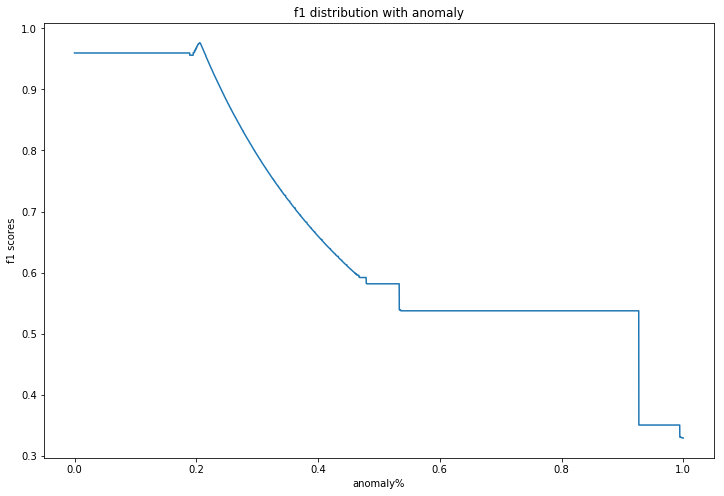

0.2056


In [60]:
anomaly_percentage_vals = np.array(anomaly_percentage_vals)/10000
f1_vals = np.array(f1_vals)
print(f1_vals.max())

plt.plot(anomaly_percentage_vals, f1_vals,
         label=["normal", "anomaly"])

plt.title("f1 distribution with anomaly")
plt.xlabel("anomaly%")
plt.ylabel("f1 scores")
plt.show()

idx = np.where(f1_vals == f1_vals.max())
print(anomaly_percentage_vals[idx].mean())

0.999999999777129


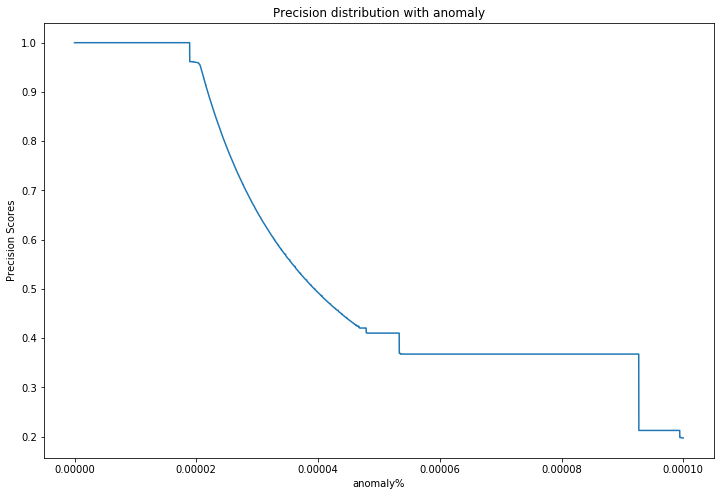

2.056e-05


In [61]:
anomaly_percentage_vals = np.array(anomaly_percentage_vals)/10000
precision_vals = np.array(precision_vals)
print(precision_vals.max())

plt.plot(anomaly_percentage_vals, precision_vals,
         label=["normal", "anomaly"])

plt.title("Precision distribution with anomaly")
plt.xlabel("anomaly%")
plt.ylabel("Precision Scores")
plt.show()

idx = np.where(f1_vals == f1_vals.max())
print(anomaly_percentage_vals[idx].mean())